# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

# Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

We will use lenskit for training, running, and evaluating recommender algorithms

In [3]:
from lenskit import topn
from lenskit.metrics.predict import rmse

# Load Data

We specify the dataset we will use for our analysis and the main directory from where we read the recommendation and prediction files. From the main directory we find all the directories associated with the dataset and then read the recommendation and predictions files from those directories.

In [4]:
dataset = "ml100k"

In [5]:
output_root = Path("output")

In [6]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [7]:
recs = []
for fld in dirs: 
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file, sep=',')
        rec["dataset"] = fld.name.split("-")[0]
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'dataset': 'category', 'algorithm': 'category'})

In [8]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file, sep=',')
        pred["dataset"] = fld.name.split("-")[0]
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)

We need to load the test data so that we have the ground truths for computing accuracy 

In [9]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [10]:
test = []
for file in split_dir.glob("test-*.csv"):
    test.append(pd.read_csv(file, sep=','))

test = pd.concat(test, ignore_index=True)

# Compute Metrics

The topn.RecListAnalysis class computes top-N metrics for recommendation list and takes care of making sure that the recommendations and ground truths are properly matched. Refer to the documentation for detailed explanation of the purpose for the RecListAnalysis class and how the analysis is done - https://lkpy.lenskit.org/en/stable/evaluation/topn-metrics.html 

In [11]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

nrecs  precision  recip_rank      ndcg  ntruth
dataset algorithm user                                                
ml100k  ALS       1     100.0       0.02    0.012987  0.104092       5
                  2     100.0       0.02    0.017241  0.102944       5
                  3     100.0       0.01    0.013333  0.028531       5
                  4     100.0       0.00    0.000000  0.000000       5
                  5     100.0       0.00    0.000000  0.000000       5

We will reshape the 'results' dataframe by stacking the columns to index and then use the bar chart to visualize the performance of our algorithms with respect to the precision, reciprocal rank and ndcg metrics

In [12]:
pltData = (results.drop(columns=['nrecs', 'ntruth']).stack()).reset_index().drop(columns=['dataset'])
pltData.columns = ['algorithm', 'user', 'metric', 'val']
pltData.head()

,algorithm,user,metric,val
0,ALS,1,precision,0.020000
1,ALS,1,recip_rank,0.012987
2,ALS,1,ndcg,0.104092
3,ALS,2,precision,0.020000
4,ALS,2,recip_rank,0.017241


We need to determine if the differences we observe in the performances of the algorithms for the various metrics are statistically significant. To achieve this, we will need to use either a parametric or non-parametric statistical test for comparing the differences. We will consider a parametric test - repeated ANOVA measure cause our sample groups are correlated.

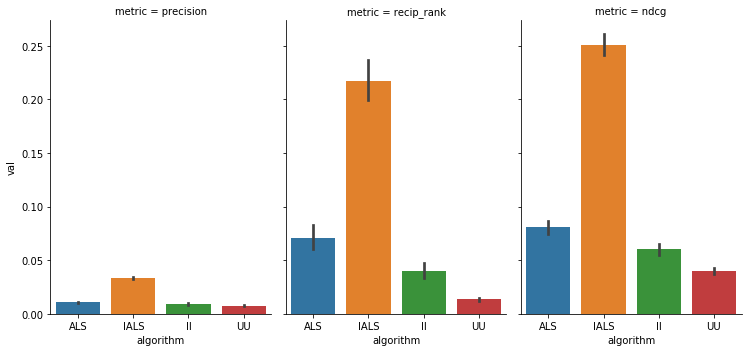

In [13]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=.7)

We will use a nonparametric statistical method to check the statistical significance of the performances for the different metrics.

# Precision

#### Friedman Test - nonparametric version of the repeated measures ANOVA

* Null hypothesis - H0: There are no differences between the related groups<br>
* Alternative hypothesis - Ha: There are differences somewhere between the related groups

In [14]:
alg_vals = []
alg_names = []
for alg, data in (results.reset_index()).groupby("algorithm"):
    alg_names.append(alg)
    alg_vals.append(data["precision"].to_numpy())

stat, p = friedmanchisquare(alg_vals[0], alg_vals[1], alg_vals[2], alg_vals[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1687.971, p=0.000


If p < 0.05, we reject the null hypothesis in favour of the alternative hypothesis that there exists differences. However, we do not know exactly where those differences lie. 

#### Post Hoc Tests - Wilcoxon signed-rank test with Bonferroni adjustment

To examine where the differences actually occur, we need to run separate Wilcoxon signed-rank tests on the different combinations of the algorithms. (However, we only perform the Post-Hoc test when the Friedman test result is statistically significant). We need to use a Bonferroni adjustment on the results from the wilcoxon tests because we are making multiple comparisons which makes it more likely that we declare a result significant when we should not.<br><br>
* Null hypothesis - H0: There is no difference between the paired results of the paired algorithm
* Alternative hypothesis - Ha: There is a difference between the paired results of the paired algorithm

In [15]:
n_compare = list(combinations(list(range(4)), 2 ))

def wilcox_bonf(data1, data2, alg_pair): 
    alpha = 0.05
    stat, p = wilcoxon(data1, data2)
    #Calculate Bonferroni adjustment
    new_alpha = alpha/len(n_compare)
    if p > new_alpha:
        decision = 'Metric is the same (fail to reject H0)'
    else:
        decision = 'Metric is different (reject H0)'
    return pd.Series({'Pair': alg_pair, 'Statistics': stat, 'p_value': p, 'Decision':decision})

for idx in n_compare:
    result = wilcox_bonf(alg_vals[idx[0]], alg_vals[idx[1]], (alg_names[idx[0]], alg_names[idx[1]]))
    print('%s, Statistics=%.3f, p-value=%.3f, %s' % (result['Pair'], result['Statistics'], result['p_value'], result['Decision']))

('ALS', 'IALS'), Statistics=8447.000, p-value=0.000, Metric is different (reject H0)
('ALS', 'II'), Statistics=16780.000, p-value=0.000, Metric is different (reject H0)
('ALS', 'UU'), Statistics=13771.000, p-value=0.000, Metric is different (reject H0)
('IALS', 'II'), Statistics=5510.000, p-value=0.000, Metric is different (reject H0)
('IALS', 'UU'), Statistics=2144.000, p-value=0.000, Metric is different (reject H0)
('II', 'UU'), Statistics=24772.500, p-value=0.000, Metric is different (reject H0)


# ndcg   

#### Friedman Test - nonparametric version of the repeated measures ANOVA

* Null hypothesis - H0: There are no differences between the related groups<br>
* Alternative hypothesis - Ha: There are differences somewhere between the related groups

In [16]:
alg_vals = []
alg_names = []
for alg, data in (results.reset_index()).groupby("algorithm"):
    alg_names.append(alg)
    alg_vals.append(data["ndcg"].to_numpy())

stat, p = friedmanchisquare(alg_vals[0], alg_vals[1], alg_vals[2], alg_vals[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1350.969, p=0.000


If p < 0.05, we reject the null hypothesis in favour of the alternative hypothesis that there exists differences. However, we do not know exactly where those differences lie. 

#### Post Hoc Tests - Wilcoxon signed-rank test with Bonferroni adjustment

We now examine where the differences actually occur using separate Wilcoxon signed-rank tests on the different combinations of the algorithms. We then adjust the result using a Bonferroni adjustment on the results. <br><br>
* Null hypothesis - H0: There is no difference between the paired results of the paired algorithm
* Alternative hypothesis - Ha: There is a difference between the paired results of the paired algorithm

In [17]:
n_compare = list(combinations(list(range(4)), 2 ))

def wilcox_bonf(data1, data2, alg_pair): 
    alpha = 0.05
    stat, p = wilcoxon(data1, data2)
    #Calculate Bonferroni adjustment
    new_alpha = alpha/len(n_compare)
    if p > new_alpha:
        decision = 'Metric is the same (fail to reject H0)'
    else:
        decision = 'Metric is different (reject H0)'
    return pd.Series({'Pair': alg_pair, 'Statistics': stat, 'p_value': p, 'Decision':decision})

for idx in n_compare:
    result = wilcox_bonf(alg_vals[idx[0]], alg_vals[idx[1]], (alg_names[idx[0]], alg_names[idx[1]]))
    print('%s, Statistics=%.3f, p-value=%.3f, %s' % (result['Pair'], result['Statistics'], result['p_value'], result['Decision']))

('ALS', 'IALS'), Statistics=39819.000, p-value=0.000, Metric is different (reject H0)
('ALS', 'II'), Statistics=55615.000, p-value=0.000, Metric is different (reject H0)
('ALS', 'UU'), Statistics=23452.500, p-value=0.000, Metric is different (reject H0)
('IALS', 'II'), Statistics=23540.000, p-value=0.000, Metric is different (reject H0)
('IALS', 'UU'), Statistics=3371.000, p-value=0.000, Metric is different (reject H0)
('II', 'UU'), Statistics=50807.000, p-value=0.000, Metric is different (reject H0)


# recip_rank

#### Friedman Test - nonparametric version of the repeated measures ANOVA

* Null hypothesis - H0: There are no differences between the related groups<br>
* Alternative hypothesis - Ha: There are differences somewhere between the related groups

In [19]:
alg_vals = []
alg_names = []
for alg, data in (results.reset_index()).groupby("algorithm"):
    alg_names.append(alg)
    alg_vals.append(data["recip_rank"].to_numpy())

stat, p = friedmanchisquare(alg_vals[0], alg_vals[1], alg_vals[2], alg_vals[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1126.858, p=0.000


If p < 0.05, we reject the null hypothesis in favour of the alternative hypothesis that there exists differences. However, we do not know exactly where those differences lie. 

#### Post Hoc Tests - Wilcoxon signed-rank test with Bonferroni adjustment

To examine where the differences actually occur, we run separate Wilcoxon signed-rank tests on the different combinations of the algorithms. We then adjust the result using a Bonferroni adjustment. <br><br>
* Null hypothesis - H0: There is no difference between the paired results of the paired algorithm
* Alternative hypothesis - Ha: There is a difference between the paired results of the paired algorithm

In [20]:
n_compare = list(combinations(list(range(4)), 2 ))

def wilcox_bonf(data1, data2, alg_pair): 
    alpha = 0.05
    stat, p = wilcoxon(data1, data2)
    #Calculate Bonferroni adjustment
    new_alpha = alpha/len(n_compare)
    if p > new_alpha:
        decision = 'Metric is the same (fail to reject H0)'
    else:
        decision = 'Metric is different (reject H0)'
    return pd.Series({'Pair': alg_pair, 'Statistics': stat, 'p_value': p, 'Decision':decision})

for idx in n_compare:
    result = wilcox_bonf(alg_vals[idx[0]], alg_vals[idx[1]], (alg_names[idx[0]], alg_names[idx[1]]))
    print('%s, Statistics=%.3f, p-value=%.3f, %s' % (result['Pair'], result['Statistics'], result['p_value'], result['Decision']))

('ALS', 'IALS'), Statistics=82067.500, p-value=0.000, Metric is different (reject H0)
('ALS', 'II'), Statistics=53654.000, p-value=0.000, Metric is different (reject H0)
('ALS', 'UU'), Statistics=16832.000, p-value=0.000, Metric is different (reject H0)
('IALS', 'II'), Statistics=53094.500, p-value=0.000, Metric is different (reject H0)
('IALS', 'UU'), Statistics=10168.000, p-value=0.000, Metric is different (reject H0)
('II', 'UU'), Statistics=46026.500, p-value=0.000, Metric is different (reject H0)
